# Machine Learning Mini Project : Weather and Climate Prediction
---

Completed 05-01-2021

---


# 1. Introduction

The first (compulsory) purpose of this notebook is to attempt to build usable predictive models of the weather at specific locations around the Earth. Throughout this section, the metrics assessed are the minimum / maximum temperatures (TMIN, TMAX), the precipitation level (PRCP) and, where possible, snow depth (SNWD). These were selected, as the first three were fairly universal between stations, while many other metrics proved to be either unmeasured, or too intermittent to be useful. 

This section is divided into three main tasks:

1. Build a model to predict TMIN, TMAX, PRCP and SNWD 30 days in advance, covering the period from October 2020 onwards.
2. Build another model, this time to predict monthly averages, a year in advance.
3. Try to build a model that can predict the next day's weather with better accuracy than simply assuming it will be the same as the day before. 

In addition, two extensions were undertaken

1. In this notebook: Interactive historical / predicted global Earth climate map from 1950 - 2040
2. In the `NASA_insight` notebook: Functional predictive models of Martian weather systems using data from NASA's InSight Lander

The first is an interactive temperature map of the world, using the monthly average of all 990 stations. This ingests all historical data (1950-2020), and uses a climate model to predict out to 2040. This is aggregated and made into a heatmap, allowing for each month to be studied, providing statistics on the hottest and coldest station in each case.

The second extension is arguably more interesting, retrieving the complete (~535 sols thus far) mission data from the NASA InSight Mars lander, and builds accurate predictive models of temperature, wind speed and direction. This allows for accurate hourly predictions of weather, as well as accurate 30-day temperature predictions. While not strictly using GHCND data, it was deemed similar enough in scope to be included.

__The text in these notebooks exclusively exists as annotations to help follow the code - for analysis and commentary on the results, see the full report.__

__Additionally, note that the data preparation for the interactive map, predicting the weather at all 990 stations, takes up to 25 minutes even with a GPU. Screenshots from it are included in the section as a time saver, if preferable.__

# 2. Setup

## 2.1 Imports
---
First, the standard modules are imported, with one or two additions. In addition to Numpy, Tensorflow and Keras, the warnings and ipywidgets modules are included. Warnings were included to suppress two edge cases, specifically related to ragged arrays. This only presented an issue during the first extension task, where stations had varying amounts of monthly data, meaning the aggregated data array was ragged, thus throwing a warning. ipywidgets were included for the same task, so that a slider could be used to control the date for the map

In [ ]:
#Standard imports
import urllib
from datetime import *
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import math
from tensorflow import keras

#Import warnings and ipywidgets for the climate map
import warnings
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#Suppress specific warnings to prevent cluttering the output
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", category=DeprecationWarning)            
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 


## 2.2 GHCND functions
---
These were provided with the task notebook, and are responsible for processing the GHCND datasets into enumerable formats for later. There is an unhandled exception in the `GHNCD.getVar()` method.

```
for month in statDict[varName]['monthList']
```
This will raise a `KeyError` if a station doesn't have the requested `varName`. 
This was left unchanged, specifically because this error later allows for incomplete data to be excluded from the climate map, and because there are enough mitigation methods in place to control it, especially the lack of user input.

In [ ]:

#Class that keeps information about station name and location
class Station():
    def __init__(self,sid,lat,lon,el,state,name,gsn,hcn,wmo,country):
        self.sid=sid
        self.lat=lat
        self.lon=lon
        self.el=el
        self.state=state
        self.name=name
        self.gsn=gsn
        self.hcn=hcn
        self.wmo=wmo
        self.country=country
        
    def __str__(self):
        return self.sid+" is "+self.name+", "+self.country+" at "+str(self.lat)+", "+str(self.lon)+", "+str(self.el)

#Class that hides some ugly reading routines
class GHNCD:
     
    #Class constructor
    def __init__(self): 
        self.station_col_len = [11,4,2,4]
        for i in range(31):
            self.station_col_len.append(5)
            self.station_col_len.append(3)
    
    # Split up the fixed length text arrays into fields
    def chunkstring(self,string, lengths):
        return (string[pos:pos+length].strip() 
                for idx,length in enumerate(lengths)
                for pos in [sum(map(int, lengths[:idx]))])

    # Process a file and extract all the information into a dictionary
    def processFile(self,fileName):
        outDict={} #
        with open(fileName, 'r') as fp: # Open file
            line = fp.readline()  #Read first line
            while line: # Process line
                fields = list(self.chunkstring(line, self.station_col_len)) #Get list of fields
                
                # For clarity use some variable names
                station=fields[0]  
                year=int(fields[1])
                month=int(fields[2])
                field=fields[3]
                vals=fields[4::2]
                flags=fields[5::2]
                # Not clear this is the only check we need, but for now
                def checkInt(x,flag):
                    if flag=='':
                        return -9999
                    return int(x)
                
                #Convert missing entries to -9999 using this swishy bit of string comprehension
                ivals=[checkInt(x,flag) for (x,flag) in zip(vals,flags)]
                monthDict=dict(year=year,month=month,field=field,vals=ivals,flags=flags)
                if field in outDict.keys():
                    outDict[field]['monthList'].append(monthDict)
                else:
                    fieldDict=dict(monthList=[monthDict])
                    outDict[field]=fieldDict
                line = fp.readline()
        return dict(outDict) #Return a copy
    
    def readCountriesFile(self,fileName=None):
        self.countryDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            c=str(line[0:2], 'utf-8')
            d=str(line[3:-2], 'utf-8')                  
            self.countryDict[c]=d
        print("Read",len(self.countryDict),"countries and codes")
        
    
    def readStationsFile(self,fileName=None,justGSN=True):
        
        #------------------------------
        #Variable   Columns   Type
        #------------------------------
        #ID            1-11   Character
        #LATITUDE     13-20   Real
        #LONGITUDE    22-30   Real
        #ELEVATION    32-37   Real
        #STATE        39-40   Character
        #NAME         42-71   Character
        #GSN FLAG     73-75   Character
        #HCN/CRN FLAG 77-79   Character
        #WMO ID       81-85   Character
        #------------------------------
        self.stationDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            sid=str(line[0:11], 'utf-8')
            lat=float(str(line[12:20], 'utf-8'))
            lon=float(str(line[21:30], 'utf-8'))
            el=float(str(line[31:37], 'utf-8'))
            state=str(line[38:40], 'utf-8')
            name=str(line[41:71], 'utf-8')
            gsn=str(line[72:75], 'utf-8')
            hcn=str(line[76:79], 'utf-8')
            wmo=str(line[80:85], 'utf-8')
            
           
            if justGSN:
                if gsn=='   ':
                    continue
            self.stationDict[sid]=Station(sid,lat,lon,el,state,name.rstrip(),gsn,hcn,wmo,self.countryDict[sid[0:2]])
        print("Read",len(self.stationDict),"stations with justGSN",justGSN)

    # Get all the data for a given variable type
    def getVar(self,statDict,varName='TMAX'):
        #The TMIN, TMAX, PRCP are all quoted in tenths (so need to be multipied by 0.1)
        cal=0.1
        if varName=='SNOW' or varName=='SNWD':
            cal=1.0
        tempList=[ (date(month['year'],month['month'],ind+1),cal*val)  for month in statDict[varName]['monthList'] for ind, val in enumerate(month['vals']) if val!=-9999   ] #Potential KeyError if invalid varName
        return tempList
    
    def getTMAX(self,statDict):
        return self.getVar(statDict,'TMAX')
    
    def printStation(self,sid):
        print(self.stationDict[sid])
        
    def getStation(self,sid):
        return self.stationDict[sid]
        
    def getStatKeyNames(self):
        #print(self.stationDict.keys())
        return [*self.stationDict.keys()]
        
    

Again, this is from the basic task script, and initialises the `ghn` object, which can be used later to retrieve station-specific data.

In [ ]:
#Initialise the ghn object, and parse in the data
ghn=GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()

# Get list of station names
statNames=ghn.getStatKeyNames()

Read 219 countries and codes
Read 991 stations with justGSN True


## 2.3 Data sanitisation and formatting
---
Here, two functions are defined:

`getWindow1D` is relatively trivial, constructing arrays representing slices of a linear array, to allow training batches to be made for simple datasets.

`getSequentialDatapoints` is likely the most important function for this section, and is responsible for correctly formatting the weather data, as well as accounting for the myriad missing datapoints. The networks require consecutive days' weather measurements to be inputted to allow for a valid prediction. However, not all days have all the measurements, and at times whole days are lacking measurements.

To account for this, the function first excludes days where the requested values (e.g TMIN, TMAX, PRCP and SNWD) weren't all measured. Next, it iterates over the data and constructs arrays of `windowSize` consecutive days. Lastly, these batches, representing the training inputs, are limited to those with valid labels / outputs. For a 30 day prediction, the array is checked to see if a measurement was made 30 days later that can be used as a label. If not, the code can search within a specified interval `maxPredError` for a "close enough" estimate. 

This method ensures that the training data is correct, and that a given training input does indeed result in its label (rather than having data where the inputs are in fact several days apart, or the label is on the other side of a one month gap in measurements). 

In [ ]:
def getWindow1D(inData, windowsize):
  '''
  Builds an array of windows from a given input array.

  Inputs:
  inData (ARR)
                  1D array of values
  windowSize (INT)
                  the width of a window in elements

  Returns:
                  An array of windows, each of size windowSize.
  '''
  data = []
  for i in range(0, len(inData)-windowsize):
    data.append(np.array(inData[i:i+windowsize]))
  return np.array(data).astype(np.float32)

In [ ]:
def getSequentialDatapoints(whichStat, dataKeys=['TMAX', 'TMIN', 'PRCP', 'SNWD'], windowSize=10, maxTimeInterval=3, predTime=30, maxPredError=0, normalise=True, targetMonths=range(1,13)):
    '''
    Takes four measurement types and produces a cohesive dataset, excluding missing measurements or large leaps in time. 
    Data that fails to satisfy the parameters is discarded entirely.
  
    Inputs:
    
    whichStat (INT)
                0-990, integer identifier for the station to get data from 

    windowSize (INT)
                The number of sequential measurements to place in each set of training data. Higher windowsizes may result
                in lower overall training inputs returned, as the chance of a larger window having at least one gap in 
                measurments is higher.
                 
    maxTimeInterval (INT)
                The maximum time (in days) allowable between measurements. Setting this to 1 means there can be no
                gap in measurementes (as every measurement must be the 1 day after the previous). Lower values will reduce
                dataset size, but result in higher quality training data.
                
    predTime (INT)
                How many days into the future to predict
                
    maxPredError (INT)
                If there isn't a measurment exactly (predTime) days into the future, how many days before or after that date
                is the function allowed to look to find a "close enough" prediction.
                
    Returns:
    
    dataSequences (ARR)
                The training inputs in the shape (num inputs, window size, 4). Essentially an array of windows, the elements
                of which are 4-vectors containing each of the measurements on that day. 
                
    predictionValues (ARR)
                The predictions for the training inputs, of shape (num inputs, 4).

    dates (ARR)
                The dates of the labels (predictionValues), of shape (numInputs, 1)
    
    means, stds (ARR)
                The means and standard deviations of each parameter, both shape (4)
    
    '''

    #Get the filename for this station
    fileName=statNames[whichStat]+'.dly'
    urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

    #Download and process the data
    urllib.request.urlretrieve(urlName,fileName)
    statDict=ghn.processFile(fileName)
    print(ghn.getStation(statNames[whichStat]))

    #Get the arrays of measurements. These names are purely illustrative.
    tmaxArray=np.array(ghn.getVar(statDict,dataKeys[0]))
    tminArray=np.array(ghn.getVar(statDict,dataKeys[1]))
    prcpArray=np.array(ghn.getVar(statDict,dataKeys[2]))
    snowArray=np.array(ghn.getVar(statDict,dataKeys[3]))


    #Convert them to dictionaries so we can retrieve values by date
    tmaxDict = dict(tmaxArray)
    tminDict = dict(tminArray)
    snowDict = dict(snowArray)
    prcpDict = dict(prcpArray)

    #List for storing all the overlapping measurements
    combArray = []

    #Iterate over the tmax array, and if all four measurements were taken on that day, save their results into the array
    #along with the date
    for i in range(0, len(tmaxArray)):
        x = tmaxArray[i][0]
        if (x in tminArray[:,0] and x in snowArray[:,0] and x in prcpArray[:,0]):
          if x.month in targetMonths:
            combArray.append([x, tmaxDict[x], tminDict[x], prcpDict[x], snowDict[x]])

    #Cast to an np array
    combArray = np.array(combArray)
    
    #Iterate over the dates, and save the same array again, but with the time since last measurement instead of the date
    timeDeltas = []
    for i in range(1, len(combArray)):
        timeDeltas.append([(combArray[i][0] - combArray[i-1][0]).days, *combArray[i][0:]])
    timeDeltas = np.array(timeDeltas)
    
    #Variables for storing the input sequence (historical data) and the result (the measurements at some point in the future)
    dataSequences = []
    predictionValues = []
    dates = []

    #Iterate through the data
    for i in range(0, len(timeDeltas)-windowSize-predTime):
        
        #Select a set of (windowSize) data points and get their time offsets from each other
        sequence = list(timeDeltas[i:i+windowSize,0])
        
        #Search for a close prediction value
        if(max(sequence) <= maxTimeInterval):
            
            #How many days into the future the time deltas add up to for a certain data point
            cumulativeOffset = 0

            #Iterate over the next few measurements, to see which is closest to predTime
            for t in range(1, predTime+1):
                
                #Save the previous offset
                priorOffset = cumulativeOffset
                
                #Add the delta T to the offset for the next datapoint (summing the deltas gives the total time into the future)
                cumulativeOffset += timeDeltas[i+windowSize+t][0]
                
                #If we're bang on, save the input sequence and the prediction and quit the loop
                if cumulativeOffset == predTime:
                    predictionValues.append(timeDeltas[i+windowSize+t][2:])
                    dataSequences.append(timeDeltas[i:i+windowSize,2:])
                    dates.append(timeDeltas[i+windowSize+t,1])
                    break
                    
                #Otherwise, chose the closest (within reason) value on either side.
                else:
                     if(cumulativeOffset > predTime and priorOffset < predTime):
                            currDiff = cumulativeOffset - predTime
                            priorDiff = predTime - priorOffset

                            #If this is closer to the prediction time and within the error
                            if (currDiff < priorDiff and currDiff <= maxPredError):
                                predictionValues.append(timeDeltas[i+windowSize+t][2:])
                                dataSequences.append(timeDeltas[i:i+windowSize,2:])
                                dates.append(timeDeltas[i+windowSize+t,1])            #NOTE THAT THE RETURNED DATES ARE THE DATES OF THE PREDICTIONS
                                break
                            
                            #If the previous one is closer and within the error
                            elif (priorDiff < currDiff and priorDiff <= maxPredError):
                                predictionValues.append(timeDeltas[i+windowSize+t-1][2:])
                                dataSequences.append(timeDeltas[i:i+windowSize,2:])
                                dates.append(timeDeltas[i+windowSize+t,1])
                                break
                            
                            #Otherwise both measurements are invalid
                            else:
                                break
                                
    #Retype the arrays as float32s to prevent tensorflow type errors
    predictionValues= np.array(predictionValues).astype(np.float32)                          
    dataSequences=np.array(dataSequences).astype(np.float32)

    #Lists to store the means and standard deviations of the sequences
    means = []
    stds = []

    #Normalise the data (if requested)
    for i in range(0, 4):
      mean = np.mean(dataSequences[:,:,i].flatten())
      std = np.std(dataSequences[:,:,i].flatten())
      if normalise:
        dataSequences[:,:,i] -= mean
        dataSequences[:,:,i] /= std
        predictionValues[:,i] -= mean
        predictionValues[:,i] /= std 
      means.append(mean)
      stds.append(std)

    dates = np.array(dates)

    #Return the training batches, labels, the dates of the labels, and means / standard deviations
    return dataSequences, predictionValues, dates, means, stds

## 2.4 Model definitions and training functions
---
Four template models are used for the weather and climate predictions. The first two are single-input single-output, with the `alt` versions being significantly less complex. The same is true of the dual-input dual-output networks, where the `alt` version lacks many of the layers of the other. This was done to allow networks of appropriate complexity to be used for each task in order to save computation time.

Two functions,`trainModel1D` and `trainModel2D` are defined for building and training new models of different dimensionalities, as well of varying complexity. This was done to simplify the number of function calls made later.

In [ ]:
def getModel1D():
    '''
    Returns an unfitted LSTM model with Two hidden layers, one LSTM and one Dense
    
    '''
    model=keras.models.Sequential()
    model.add(keras.layers.LSTM(32,input_shape=(None,1),return_sequences=False))
    model.add(keras.layers.Dense(20,activation="linear"))
    model.add(keras.layers.Dense(1,activation="linear"))

    model.compile(loss='mean_absolute_error',optimizer='adam')
    return model

def getModel1D_alt():
    '''
    Returns an unfitted LSTM model with a single LSTM hidden layer
    
    '''
    model=keras.models.Sequential()
    model.add(keras.layers.LSTM(8,input_shape=(None,1),return_sequences=False))
    model.add(keras.layers.Dense(1,activation="linear"))

    model.compile(loss='mean_absolute_error',optimizer='adam')
    return model



def getModel2D():
    '''
    Returns an unfitted dual input network with several LSTM layers
    
    '''
    model=keras.models.Sequential()
    model.add(keras.layers.LSTM(128,input_shape=(None,2),return_sequences=True))
    model.add(keras.layers.LSTM(64,return_sequences=True))
    model.add(keras.layers.LSTM(128,return_sequences=True))
    model.add(keras.layers.LSTM(64,return_sequences=False))
    model.add(keras.layers.Dense(64, activation="linear"))
    model.add(keras.layers.Dense(2,activation="linear"))

    model.compile(loss='mean_absolute_error',optimizer='adam')
    return model


def getModel2D_alt():
  '''
  Returns an unfitted dual input network with two LSTM and one dense layer
  
  '''
  model=keras.models.Sequential()
  model.add(keras.layers.LSTM(64,input_shape=(None,2),return_sequences=True))
  model.add(keras.layers.LSTM(32,return_sequences=False))
  model.add(keras.layers.Dense(8, activation="linear"))
  model.add(keras.layers.Dense(2,activation="linear"))

  model.compile(loss='mean_absolute_error',optimizer='adam')
  return model


def trainModel2D(trainData, trainLabels, splitIndex, validationRatio, N_batches, N_epochs, alt=False, verb=0):
  '''
  Trains a dual-input model on a given set of data, with customisable ratios for training and valdation.

  Inputs

  trainData (ARR)
              The data to use for the fitting (training and validation), shape (batches, windowsize, 2)
  
  trainLabels (ARR)
              The labels for the data, shape (batches, 2)

  splitIndex (INT)
              The index of the last datapoint to use (the end of the validation array), marking where the test data starts
  
  validationRatio (FLOAT)
              The fraction of the training data to use as validation data

  N_batches, N_epochs (INT)
              The batchsize and number of training epochs to use in fitting respectively

  alt (BOOL)
              Boolean, whether to use the simpler model type
  
  verb (INT)
              Integer, set the verbosity level (0=silent, 1=verbose)
  '''
  weatherModel2D = None 
  if alt:
    weatherModel2D = getModel2D_alt()
  else:
    weatherModel2D = getModel2D()

  validationIndex = int(splitIndex * (1. - validationRatio))

  costs = weatherModel2D.fit(trainData[:validationIndex], trainLabels[:validationIndex], batch_size=N_batches, epochs=N_epochs, validation_data=(trainData[validationIndex:], trainLabels[validationIndex:]), verbose=verb)
  return weatherModel2D, costs


def trainModel1D(trainData, trainLabels, splitIndex, validationRatio, N_batches, N_epochs, alt=False, verb=0):
  '''
  Trains a single-input model on a given set of data, with customisable ratios for training and valdation.

  Inputs

  trainData (ARR)
              The data to use for the fitting (training and validation), shape (batches, windowsize, 2)
  
  trainLabels (ARR)
              The labels for the data, shape (batches, 2)

  splitIndex (INT)
              The index of the last datapoint to use (the end of the validation array), marking where the test data starts
  
  validationRatio (FLOAT)
              The fraction of the training data to use as validation data

  N_batches, N_epochs (INT)
              The batchsize and number of training epochs to use in fitting respectively

  alt (BOOL)
              Boolean, whether to use the simpler model type
  
  verb (INT)
              Integer, set the verbosity level (0=silent, 1=verbose)
  '''
  weatherModel1D = None
  if alt:
    weatherModel1D = getModel1D_alt()
  else:
    weatherModel1D = getModel1D()

  validationIndex = int(splitIndex * (1. - validationRatio))

  costs = weatherModel1D.fit(trainData[:validationIndex], trainLabels[:validationIndex], batch_size=N_batches, epochs=N_epochs, validation_data=(trainData[validationIndex:], trainLabels[validationIndex:]), verbose=verb)
  return weatherModel1D, costs



## 2.5 Auxiliary data handling functions
---
The final set of functions used for this section of analysis are a group of data processing functions, used for interpreting results rather than directly impacting their calculations.

`smoothData` applies a basic smoothing function, changing each value in an array to be the weighted mean of itself and the values on either side.

`comparePredictions` is a graphing function used for comparing values predicted by a model to the "true" ones.

In [ ]:
def smoothData(data, width, weight):
  '''
  Averages datapoints to include the values of their neighbours

  Inputs:

  data (ARR)
              The input data to smooth
  
  width (INT)
              The number of values on either side to average across
  
  weight (FLOAT)
              How much to weight the values on either side (likely less than zero)

  Outputs:

  ret (ARR)
              The smoothed array
  '''

  ret = []
  for i in range(0, width):
    ret.append(data[i])
  for i in range(width, len(data) - width):
    ret.append((sum(data[i-width:i])*weight + data[i] + weight*sum(data[i+1:i+width]))/(1+2*width) )
  ret = np.array(ret)
  return ret

In [ ]:
def comparePredictions(model, testData, testLabels, predictionDates, axislabels=[], plottitles=[], useAltTestData=False, altTestData=None, altDates=None):
  '''
  Compare the predictions of a 2D model on a a given set of data to the actual values

  Inputs:
  
  model (NN)
              The trained network to use for the predictions

  testData, testLabels (ARR)
              The input data and the correct prediction values
    
  predictionDates (ARR)
              The dates that the predicted values correspond to, useful for correctly aligning the values on the x axis
  
  useAltTestData (BOOL)
              Whether some extra prediction data is supplied to predict on, useful for comparing values predicted on the true inputs,
              and the values predicted using the outputs of some other model at the same time
  
  altTestData (ARR)
              The alternate input set to use only used if useAltTestData is True
  
  altDates (ARR)
              The array of dates that the alternate test data corresponds to

  Outputs:
             Two or three subplots showing the predictions of the network compared to the real values 
  '''
  #Predict using the input data
  predictions = model.predict_on_batch(testData)
  altPredictions = None

  #If alternate data has been supplied, add an extra subplot to the total to make
  #and predict on the alternate data too
  if useAltTestData:
    altPredictions = model.predict_on_batch(altTestData)

  #Plot the real data, data predicted on the test inputs, and data predicted on the alt. inputs
  fig, ax = plt.subplots(1,2, figsize=(30,6))

  ax[0].plot(predictionDates, testLabels[:,0], 'b--', label="Actual")
  ax[0].plot(predictionDates, predictions[:,0], 'b-', label="Predicted")
  ax[0].set_xlabel(axislabels[0])
  ax[0].set_ylabel(axislabels[1])
  ax[0].set_title(plottitles[0])

  if useAltTestData:
    ax[1].plot(predictionDates, testLabels[:,1], 'r--', label="Actual")
    ax[1].plot(altDates, altPredictions[:,1], label="Predicted")
    ax[1].set_xlabel(axislabels[0])
    ax[1].set_ylabel(axislabels[1])
    ax[1].set_title(plottitles[1])
  else:
    ax[1].plot(predictionDates, testLabels[:,1], 'r--', label="Actual")
    ax[1].plot(predictionDates, predictions[:,1], 'r-', label="Predicted")
    ax[1].set_xlabel(axislabels[0])
    ax[1].set_ylabel(axislabels[1])
    ax[1].set_title(plottitles[1])
  ax[0].legend()
  ax[1].legend()
  return

# 3. Predicting 30 days into the future

## 3.1 Approach
---
Here, the selected station was ID#201, located in Canada. This was chosen as it had temperature, precipitation and snow depth data, as well as an acceptable number of missing values. A layered approach is used, in the following order:

1. Train a model to predict TMAX and TMIN 30 days in advance
2. Train models to use TMAX and TMIN to predict the next days PRCP and SNWD
3. Use the temperature model to predict 30 days into the future
4. Use the PRCP / SNWD model to convert the temperature predictions into precipitation and snow predictions

This was done specifically to avoid issues caused by spotty PRCP / SNWD data, which wasn't measured regularly, preventing a full TMAX+TMIN+PRCP+SNWD four-input model from being a viable solution. Instead, this more general approach made better use of the available data, and allowed for generic predictions to be made given any set of temperature values.

## 3.2 Temperature modelling
---
First, the temperature-only data is retrieved from the database. The parameters `["TMAX", "TMIN", "TMAX", "TMIN"]` are supplied to the `getSequentialDatapoints` function to get data for predicting TMAX / TMIN using TMAX and TMIN as inputs. As the temperature data is relatively abundant, the training data is limited to the August-December period to get better predictions of autumnal / winter temperature variations. 

Training window sizes of 9 days are used, with a maximum time between measurements of 2 days, and a prediction time of 30 days.

In [ ]:
temp_ins, temp_outs, temp_in_dates, temp_means, temp_stds =  getSequentialDatapoints(201, dataKeys=["TMAX", "TMIN", "TMAX", "TMIN"], windowSize=9,maxTimeInterval=2, predTime=30, maxPredError=0, normalise=True, targetMonths=range(8, 13))

CA002100693 is MACMILLAN PASS, Canada at 63.25, -130.0333, 1379.0


As the task specifically requests that the training set be up to the end of September 2020, the dataset is iterated over to find the index of the first value after 30-09-2020, denoting the beginning of the test data.

In [ ]:
tempSplitIndex = 0
tempFinalPredictionDate = date(2020,9,30)

#Iterate over the data and find the beginning of the test data
for i in range(0, len(temp_in_dates)):
  if temp_in_dates[i] >= tempFinalPredictionDate:
    tempSplitIndex = i
    break

Next, a model is trained on the data over 250 epochs, using a batch size of 100 windows. 20% of the dataset is set aside for validation. The loss and validation lost are shown below.

In [ ]:
#Train a dual input model to predict the temperature
tempModel2D, tempCosts = trainModel2D(temp_ins[:,:,:2], temp_outs[:,:2], tempSplitIndex, 0.2, 100, 250, verb=0) #250 is a good value

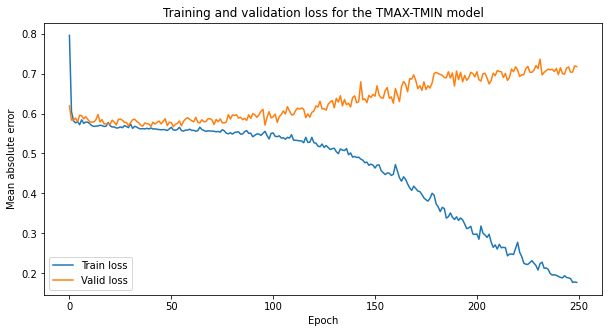

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and validation loss for the TMAX-TMIN model")
plt.plot(tempCosts.history["loss"], label="Train loss")
plt.plot(tempCosts.history["val_loss"], label="Valid loss")
plt.ylabel("Mean absolute error")
plt.xlabel("Epoch")
plt.legend()

With the model now trained, it can be fed to the `comparePredictions` function to show the difference between predicted and actual temperatures. 

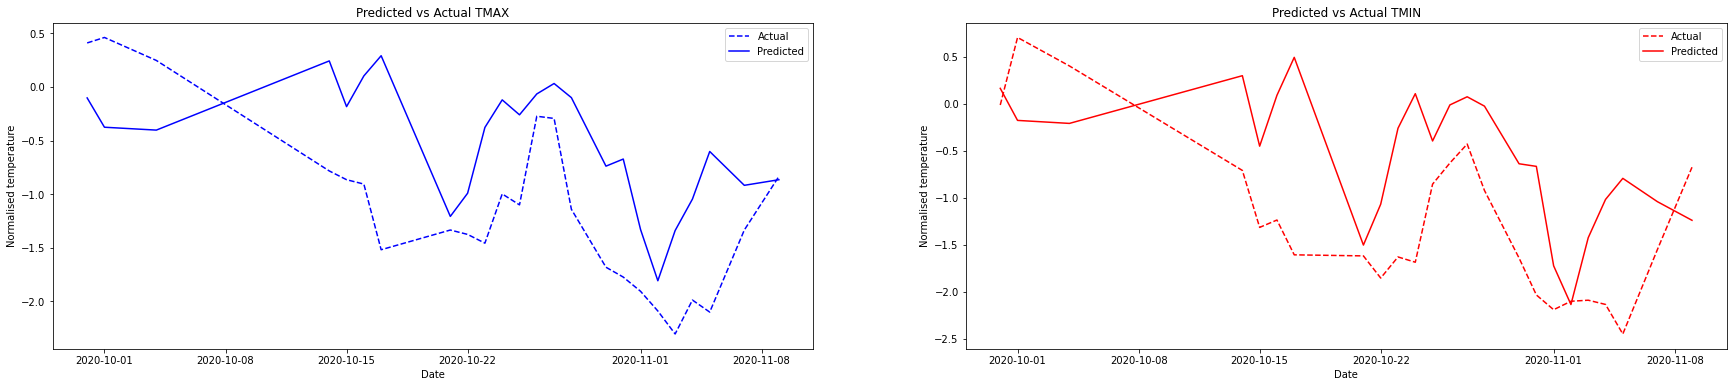

In [ ]:
temp_axlabels = ["Date", "Normalised temperature"]
temp_titles = ["Predicted vs Actual TMAX", "Predicted vs Actual TMIN"]
comparePredictions(tempModel2D, temp_ins[tempSplitIndex:,:,:2], temp_outs[tempSplitIndex:,:2], temp_in_dates[tempSplitIndex:], temp_axlabels, temp_titles)

## 3.3 Precipitation modelling using temperature
---
Next, this process is repeated, except that the labels/outputs are reconfigured to be the precipitation level rather than the temperature. Another dual-input model is trained on this data, with the aim of predicting the rainfall using the maximum and minimum temperature. This doesn't need to predict 30 days in advance, as it is used for translating temperature data into rainfall, so a small window size and a prediction time of 1 day is used instead.

In [ ]:
#Get data with TMAX and TMIN as the training parameters, and both outputs as PRCP
prcp_ins, prcp_outs, prcp_in_dates, prcp_means, prcp_stds =  getSequentialDatapoints(201, dataKeys=["TMAX", "TMIN", "PRCP", "PRCP"], windowSize=3,maxTimeInterval=2, predTime=1, maxPredError=1, normalise=True, targetMonths=range(1, 13))
prcpSplitIndex = 0

#As before, identify the test data splitting point
for i in range(0, len(prcp_in_dates)):
  if prcp_in_dates[i] >= tempFinalPredictionDate:
    prcpSplitIndex = i
    break

CA002100693 is MACMILLAN PASS, Canada at 63.25, -130.0333, 1379.0


Again, the model is trained in the same way as the temperature model, and the training and validation lost is displayed below.

In [ ]:
#Train the precipitation model using this data
prcpModel2D, prcpCosts = trainModel2D(prcp_ins[:,:,:2], prcp_outs[:,2:], prcpSplitIndex, 0.2, 100, 250, verb=0)

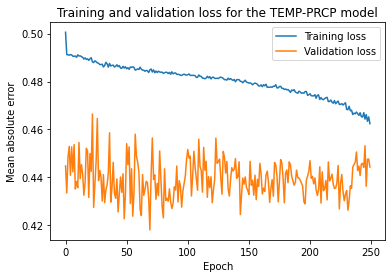

In [ ]:
#PLot the training and validation loss
plt.plot(prcpCosts.history["loss"], label="Training loss")
plt.plot(prcpCosts.history["val_loss"], label="Validation loss")
plt.title("Training and validation loss for the TEMP-PRCP model")
plt.ylabel("Mean absolute error")
plt.xlabel("Epoch")
plt.legend()

In [ ]:
#Get the predicted temperature values, and predict the rainfall using those 
predictedTempTestData = getWindow1D(tempModel2D.predict_on_batch(temp_ins[tempSplitIndex:,:,:2]), 3)
predictedTempDates = temp_in_dates[tempSplitIndex+3:]+timedelta(1)

With the training complete, the same system of prediction comparisons is carried out. Here, the function is overridden using the `useAltTestData` switch, graphing the first prediction output and the data predicted using the alternate input. This is to allow for a comparison of the model predicting on real temperatures, and predictions using the 30-day forecasted data. 

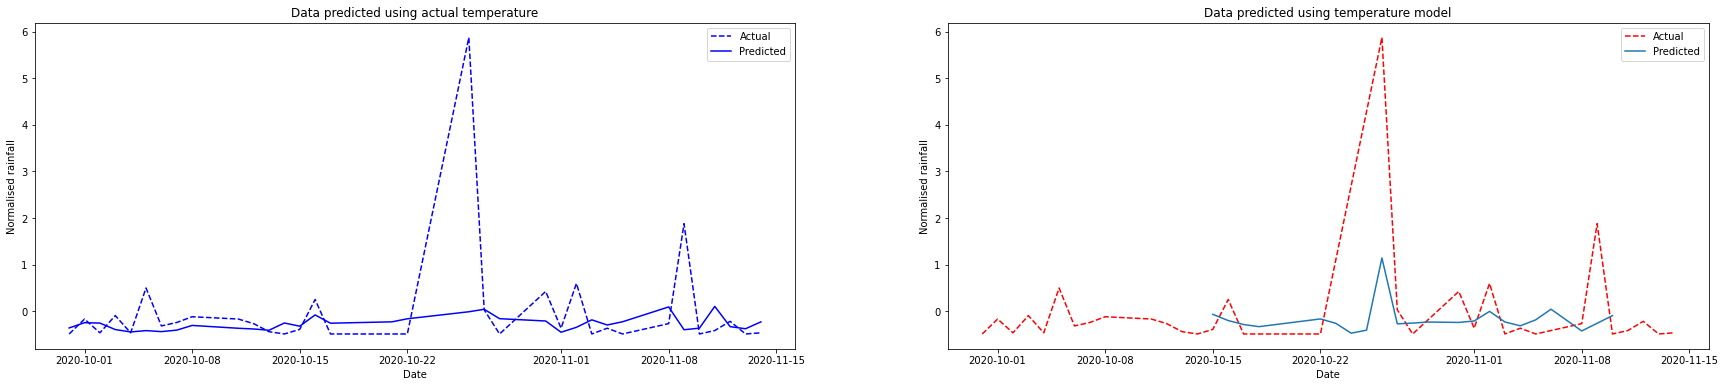

In [ ]:
#Graph the outputs of the network, along with the values derived from the predicted temperature
rain_axlabels = ["Date", "Normalised rainfall"]
rain_titles = ["Data predicted using actual temperature", "Data predicted using temperature model"]
comparePredictions(prcpModel2D, prcp_ins[prcpSplitIndex:,:,:2], prcp_outs[prcpSplitIndex:,2:], prcp_in_dates[prcpSplitIndex:], rain_axlabels, rain_titles, useAltTestData=True, altTestData=predictedTempTestData, altDates=predictedTempDates)

## 3.4 Snow depth modelling using temperature
---
Finally, an identical process to the precipitation modelling is carried out for the snow depth, using temperature as the predictor. Similar window sizes and prediction times are used to allow for the two models to be used side-by-side.

In [ ]:
#Get the data for temperature and snow depth modelling
snow_ins, snow_outs, snow_in_dates, snow_means, snow_stds =  getSequentialDatapoints(201, dataKeys=["TMAX", "TMIN", "SNWD", "SNWD"], windowSize=3,maxTimeInterval=2, predTime=1, maxPredError=1, normalise=True, targetMonths=range(8, 13))

CA002100693 is MACMILLAN PASS, Canada at 63.25, -130.0333, 1379.0


In [ ]:
#Find the splitting point
snowSplitIndex = 0
for i in range(0, len(snow_in_dates)):
  if snow_in_dates[i] >= tempFinalPredictionDate:
    snowSplitIndex = i
    break

In [ ]:
#Train the model
snowModel2D, snowCosts = trainModel2D(snow_ins[:,:,:2], snow_outs[:,2:], snowSplitIndex, 0.2, 100, 250, verb=0)

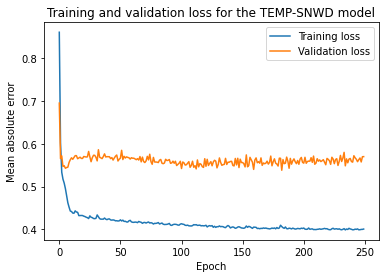

In [ ]:
#Plot the training and validation loss
plt.plot(snowCosts.history["loss"], label="Training loss")
plt.plot(snowCosts.history["val_loss"], label="Validation loss")
plt.title("Training and validation loss for the TEMP-SNWD model")
plt.ylabel("Mean absolute error")
plt.xlabel("Epoch")
plt.legend()

One final comparison is carried out here. As with the precipitation model, even predicting on the true data is relatively erroneous. However, this approach was used for its flexibility, enabling more data-agnostic predictions. This is the final model used for the 30-day predictions, as no other parameters were deemed suitable for analysis, due to the aforementioned issues with inconsistent and nonexistent data.

In [ ]:
#Predict the snowfall using the temperature, as with the precipitation
predictedTempTestData = getWindow1D(tempModel2D.predict_on_batch(temp_ins[tempSplitIndex:,:,:2]), 3)
predictedTempDates = temp_in_dates[tempSplitIndex+3:]+timedelta(1)

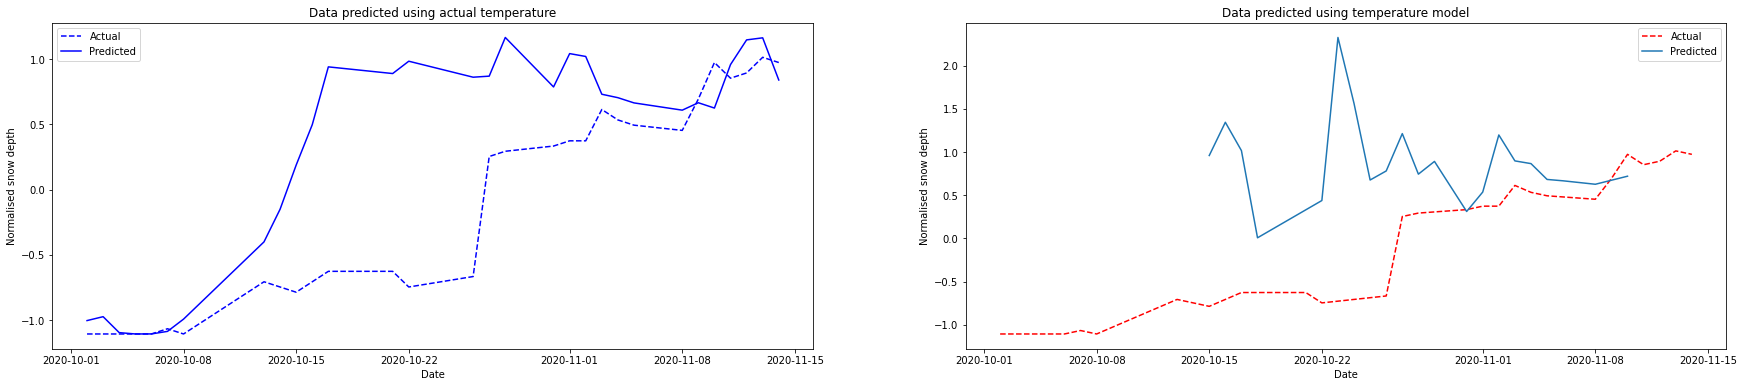

In [ ]:
#Compare the three systems
snow_axlabels = ["Date", "Normalised snow depth"]
snow_titles = ["Data predicted using actual temperature", "Data predicted using temperature model"]
comparePredictions(snowModel2D, snow_ins[snowSplitIndex:,:,:2], snow_outs[snowSplitIndex:,2:], snow_in_dates[snowSplitIndex:], snow_axlabels, snow_titles, useAltTestData=True, altTestData=predictedTempTestData, altDates=predictedTempDates)

## 3.5 Semantic weather prediction using peak detection 
---
As is evident from the graphs, this method of prediction is far from accurate. The temperature prediction certainly predicts the approximate trend in values, and can identify the large dips. The same is true, albeit more extreme, for the precipitation and snow depth, where the network generates weak signals.

 Here, we see if we can use peak detection to estimate the weather qualitatively - to identify what days might have rain or snow, rather than determining exactly how much rain or snow there might be. This is especially useful for snow depth, as changes in snow depth indicate snowfall, which is a more useful weather metric for everyday usage.

Here, peaks are defined as points with higher values than those either side, or where the gradient is positive but decreasing. The `detectPeaks` function identifies these points and returns their dates.

The `matchPredictionPeaks` function uses this to identify peaks in the real and predicted values, and checks to find both matches, where peaks occur on the same day, partial matches (within one day of each other), and mismatches (no peak nearby). This is then displayed on a graph.

In [ ]:
def detectPeaks(inDates, inData, peakType="peak"):
  '''
  Given a 1D array, identifies maxima or minima in the values, returning the dates that these occur on

  Inputs:

  inDates [ARR]
          Array containing the dates that correspond to the input data
  
  inData  [ARR]
          Array containing the values to identify peaks in
  
  peakType [STRING]
          maximum or minimum, the type of peak to identify

  Outputs:

  peakDates [ARR]
          Array containing the dates on which peaks occur
  '''
  #Return variable for the dates
  peakDates = []

  #Iterate over the data and get the gradients between the current point
  #and the ones either side
  for i in range(1, len(inData)-1):
    grad1 = inData[i] - inData[i-1]
    grad2 = inData[i] - inData[i+1]

    #Check if this point is a peak, filtering out very small peaks (less than 0.05 change either side)
    if abs(grad1) > 0.05 or abs(grad2) > 0.05:
      if peakType == "peak":
        if grad1 > 0 and (grad2 > 0 or (grad2 < 0 and abs(grad2) < grad1)):
          peakDates.append(inDates[i])
      elif peakType == "ascend":
        if grad1 > 0:
          peakDates.append(inDates[i])

  #Return the dates
  return peakDates

In [ ]:
def matchPredictionPeaks(baseDates, baseSeries, matchDates, matchSeries,maxError, mode, axislabels, plttitle, disp=True):
  '''
  Takes two sets of data, identifies the peaks in both and sees if any of them line up, returning
  the match rate.

  Inputs:
  baseDates, baseSeries [ARR]
            The dates and values of the first sequence to analyse

  matchDates, matchSeries [ARR]
            The dates and values of the second array to match to the first

  mode [STRING]
            Whether to search for the maxima or minima

  Returns:
  
  accuracy [FLOAT]
            The fraction of the peaks that match up

  '''

  #Arrays for storing matches in
  completeMatches = []
  falseMatches = []
  partialMatches = []

  #Min and max heights for the peak markers
  line_ymin = min(min(baseSeries), min(matchSeries))
  line_ymax = max(max(baseSeries), max(matchSeries))

  #Identify the peaks in each dataset
  basePeaks = detectPeaks(baseDates, baseSeries, peakType=mode)
  matchPeaks = detectPeaks(matchDates, matchSeries, peakType=mode)

  for peak in matchPeaks:

    viableDates = []
    for i in range(1, maxError):
      viableDates.append(peak+timedelta(i))
      viableDates.append(peak-timedelta(i))

    #Check for full matches
    if peak in basePeaks:
      completeMatches.append(peak)

    else:
      found = False

      #Search for peaks within the allowable forecast error
      for bp in basePeaks:
        if bp in viableDates and bp not in partialMatches and bp not in completeMatches:
          partialMatches.append(bp)
          found = True

      #If none found, count it as a mismatch
      if found == False:
        if peak < matchDates[-1] and peak > matchDates[0]:
          falseMatches.append(peak)


  if disp:
    #Draw the two data series, and mark the full, partial and mis- matches
    fig, ax = plt.subplots(1,1, figsize=(15,6))
    ax.set_title((plttitle + " +- " + str(maxError) + " days"))
    ax.set_xlabel(axislabels[0])
    ax.set_ylabel(axislabels[1])
    ax.plot(baseDates, baseSeries)
    ax.plot(matchDates, matchSeries)
    ax.set_xlim(matchDates[0], matchDates[-1])
    ax.vlines(completeMatches, line_ymin, line_ymax, 'green',linestyle="dashed")
    ax.vlines(partialMatches, line_ymin, line_ymax, 'orange', linestyle="dashed")
    ax.vlines(falseMatches, line_ymin, line_ymax, 'red', linestyle="dashed")
    
  #Calculate the ratio of matches to total peaks detected and return it
  accuracy = min(1, (len(completeMatches) + len(partialMatches))/(len(matchPeaks)))
  return accuracy

First, the predicted values for the precipitaion and snow depth were generated using the 30-day temperature predictions, using the keras `predict_on_batch` method.

In [ ]:
#Generate the predicted datasets
peakMatch_rainPreds = prcpModel2D.predict_on_batch(predictedTempTestData)[:,-1]
peakMatch_snowPreds = snowModel2D.predict_on_batch(predictedTempTestData)[:,-1]

Next, the values are run through the peak-detection functions, and aligned using `matchPredictionPeaks'. This allows for some basic accuracy metrics to be determined. The first set of data covered is the predicted rainfall. Here, the maximum forecast error allowed is 3 days, meaning that the system can search three days to either side of a peak to find a match.

[+] Peak match accuracy 0.75


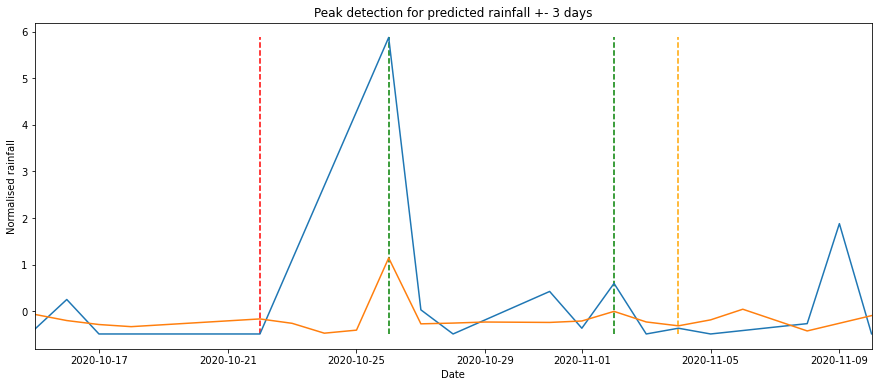

In [ ]:
#Get the peak match accuracy for the precipitation data
prcpAcc = matchPredictionPeaks(prcp_in_dates[prcpSplitIndex:], prcp_outs[prcpSplitIndex:,3], predictedTempDates, peakMatch_rainPreds, 3, "peak", ["Date", "Normalised rainfall"], "Peak detection for predicted rainfall")
print("[+] Peak match accuracy", prcpAcc)


The same process is repeated for the snow depth, shown below. Here, two changes are made. Peak detection was a reliable indicator fo rainfall, as it is not a cumulative statistic - each day's rain does not add to the next in the figures. However, snow depth is cumulative. Any increase in depth indicates snowfall. Thus, the peak detection mode is set to `ascend`, checking only that the value has increased since the last measurement. This is somewhat more sensitive to noise.

[+] Peak match accuracy 0.5


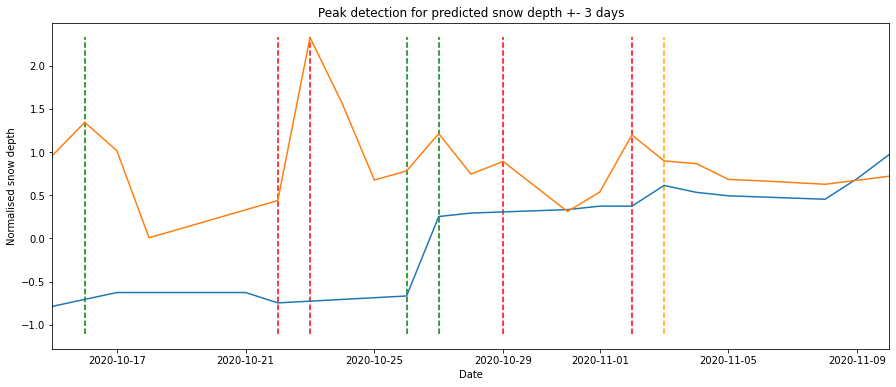

In [ ]:
#Get the peak match accuracy for the snow depth data
snowAcc = matchPredictionPeaks(snow_in_dates[snowSplitIndex:], snow_outs[snowSplitIndex:,3], predictedTempDates, peakMatch_snowPreds, 3, "ascend", ["Date", "Normalised snow depth"], "Peak detection for predicted snow depth")
print("[+] Peak match accuracy", snowAcc)

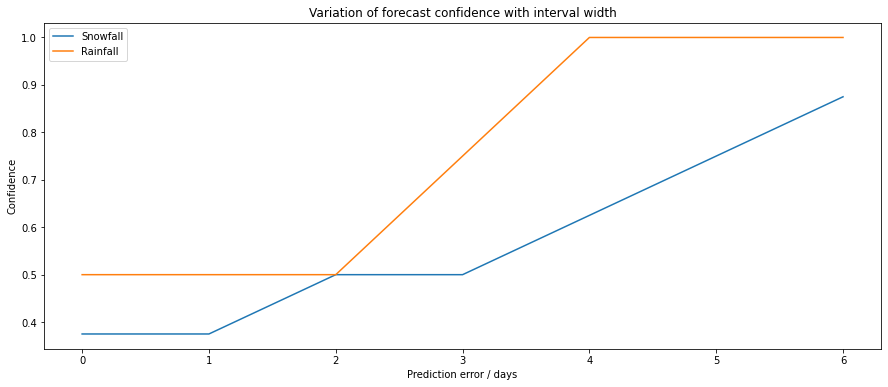

In [ ]:
snowAccArray = []
prcpAccArray = []
for i in range(0, 7):
  prcpAccArray.append(matchPredictionPeaks(prcp_in_dates[prcpSplitIndex:], prcp_outs[prcpSplitIndex:,3], predictedTempDates, peakMatch_rainPreds, i, "peak", None, None, disp=False))
  snowAccArray.append(matchPredictionPeaks(snow_in_dates[snowSplitIndex:], snow_outs[snowSplitIndex:,3], predictedTempDates, peakMatch_snowPreds, i, "ascend", None, None, disp=False))

plt.figure(figsize=(15,6))
plt.title("Variation of forecast confidence with interval width")
plt.ylabel("Confidence")
plt.xlabel("Prediction error / days")
plt.plot(snowAccArray, label="Snowfall")
plt.plot(prcpAccArray, label="Rainfall")
plt.legend()

Above is a graph of forecast confidence against the allowable prediction error. As might be expected, as the allowable error increases, the probability of there being an overlap between the predicted and actual presence of rain / snow becomes higher. This makes sense, as saying that there might be rain in the weeks either side of a predicted spike is bound to include some form of precipitation, and thus be marked as a correct prediction. Further commentary on this is provided in the report.

#4. Predicting the next day

##4.1 Approach
---
The second compulsory task undertaken was to see whether a model can be trained to predict the next days weather, with lower error than assuming it will be the same as the current day. Most of the data handling functionality had been built out at this point, so a single, relatively simple, function was used for every parameter in this task.

`compareNextDayModels` builds and trains a single input network, and uses it to predict the next days weather. An alternate set of predictions is generated by taking the last element of each training batch (the equivalent of "today's weather"), and used as the prediction for the next day.

The two sets of predictions are then compared to the true values, using the mean absolute error as the loss metric, rather than mean square error. This was done for the sake of comparison, since the climate models are trained with mean absolute error as their loss.

In [ ]:
def compareNextDayModels(statID, param, windowsize):
  '''
  For a given parameter, compare the performance of a single input network to
  a system which just predicts that the next day's weather is the same as the 
  one before.

  Inputs:
  
  statID [INT]
              Which station to get data from
  
  param [STRING]
              What value to get from the station, TMAX etc
  
  windowsize [INT]
              How large to make the training windows

  Returns:

  nextDayError, modelError [ARR]
              Arrays containing the differences between the predicted and actual
              values, for each point in time
  
  Also plots the two predictions for comparison.
  '''

  #Get the training data and labels etc.
  p_ins, p_outs, p_in_dates, p_means, p_stds = getSequentialDatapoints(statID, dataKeys=[param,param,param,param], windowSize=windowsize,maxTimeInterval=1, predTime=1, maxPredError=0, normalise=True, targetMonths=range(8, 13))

  #Set the outputs of the next day model to just be the previous input
  sameDayPreds = p_ins[:,-1,0]
  pFinalPredictionDate = date(2020,9,30)
  
  #Identify the september onwards values for comparison with the model
  for i in range(0, len(p_in_dates)):
    if p_in_dates[i] >= pFinalPredictionDate:
      pSplitIndex = i
      break

  #Train a model on the same training data, but with the proper next day labels
  pModel, pCosts = trainModel1D(p_ins[:,:,:1], p_outs[:,0], pSplitIndex, 0.2, 100, 350, verb=0, alt=True) #250 is a good value
  p_preds = pModel.predict_on_batch(p_ins[pSplitIndex:,:,:1])[:,0]

  #Calculate the mean absolute errors for the two sets of predictions
  nextDayError = np.subtract(p_outs[pSplitIndex:,0], sameDayPreds[pSplitIndex:])
  modelError = np.subtract(p_outs[pSplitIndex:,0], p_preds)

  #PLot them together
  fig, ax = plt.subplots(1,1, figsize=(15,7))
  ax.plot(p_in_dates[pSplitIndex:], p_outs[pSplitIndex:,0], label="Real")
  ax.plot(p_in_dates[pSplitIndex:], sameDayPreds[pSplitIndex:], label="Same as previous")
  ax.plot(p_in_dates[pSplitIndex:], p_preds, label="Network prediction")
  ax.set_title("Comparison of next day and NN predictions for " + param)
  ax.set_ylabel("Normalised " + param)
  ax.set_xlabel("Date")
  ax.legend()

  #Return the full sets of errors
  return nextDayError, modelError

##4.2 Comparing predictive models
---
The first parameter being assessed is TMAX. This is a relatively predictable parameter that was expected to put both predictions on relatively equal footing. The same Canadian station from before was used (ID:201). As can be seen, the models have almost identical errors, but the model's mean error is slightly lower than that of the next day model.

CA002100693 is MACMILLAN PASS, Canada at 63.25, -130.0333, 1379.0
Next day model: 0.3365924
Actual network: 0.3050682


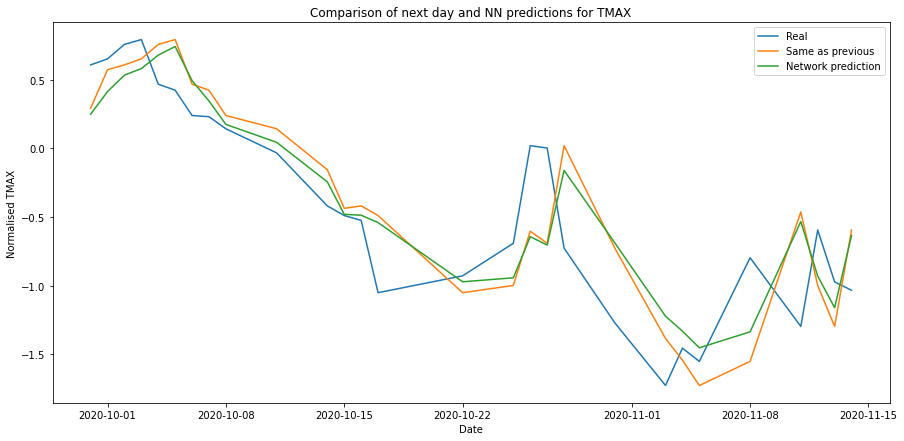

In [ ]:
#Get the differences between predicted and actual temperatures
tmaxError = compareNextDayModels(201, "TMAX", 2)
print("Next day model:",np.mean(np.absolute(tmaxError[0])))
print("Actual network:",np.mean(np.absolute(tmaxError[1])))

Next, the same process was repeated for the snow depth and as can be seen, the models are almost exactly on par with each other, with very low mean errors over the testing interval. Here, the errors remained similar and resilient to changes in the model, indicating that this is close to a performance ceiling for this particular variable.

CA002100693 is MACMILLAN PASS, Canada at 63.25, -130.0333, 1379.0
Next day model: 0.14974949
Actual network: 0.14999604


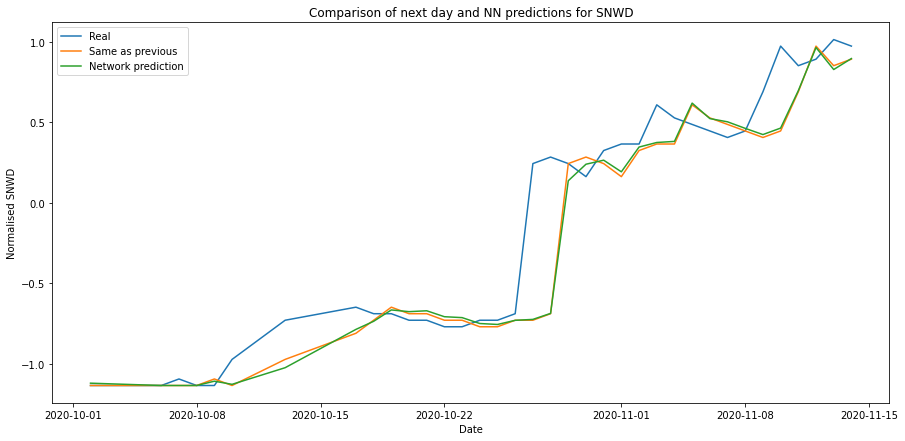

In [ ]:
#Get the diff. between snow depth models
snwdError = compareNextDayModels(201, "SNWD", 3)
print("Next day model:",np.mean(np.absolute(snwdError[0])))
print("Actual network:",np.mean(np.absolute(snwdError[1])))

The final parameter assessed is the precipitation. This is the least valid comparison of the set, as the neural network far outstrips the next-day model, but this is only because the model predicts a low baseline, which is statistically more likely to be correct, as rain only occurs on specific days.

CA002100693 is MACMILLAN PASS, Canada at 63.25, -130.0333, 1379.0
Next day model: 0.83755225
Actual network: 0.43588367


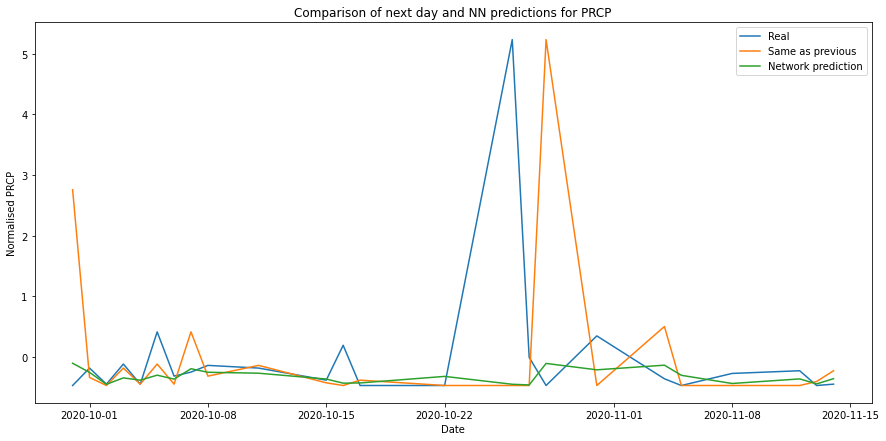

In [ ]:
#Get the diff. between precipitation models
prcpError = compareNextDayModels(201, "PRCP", 3)
print("Next day model:",np.mean(np.absolute(prcpError[0])))
print("Actual network:",np.mean(np.absolute(prcpError[1])))

#5. Climate prediction models

##5.1 Approach
---
This section is concerned with constructing a model that can predict the monthly averages for `TMAX`, `TMIN`, and `PRCP`. Snow depth was excluded from the modelling, as it was rarely present in station datasets, outside of a few high latitude ones. There are three core components to this part of the project:

1. Obtaining monthly averages by binning the daily data
2. Converting the monthly averages into a training-compatible format
3. Training models using this data
4. Applying the models to other stations

One of the key advantages of using monthly averages was that there were relatively few gaps in the dataset. While the approach established with the 30 day system already reduced the impact of this particular issue, it was reassuring to have a better data density. As such, each parameter is predicted using only itself, rather than using temperature to predict everything else.

##5.2 Data preparation
---
There are three key functions here:

`getClimateParams` reads in the station data, and calculates the monthly averages. It also normalises the monthly data for use with training.

`getCLimateTrainingData` then converts this data into network-compatible batches and labels.

`testModel` is the final function, taking trained models and running them on a variety of different data from different stations, allowing for the models to be assessed for their ability to generalise to different locations.

In [ ]:
def getClimateParams(whichStat, params, normalise, retLatLong=False):
    '''
    Calculate the monthly averages for a given dataset and parameter

    Inputs:

    whichStat [INT]
                The ID of the station to get data from
    
    params [ARR]
                The parameters to get climate data for

    normalise [BOOL]
                Whether to normalise the data
    
    retLatLong [BOOL]
                Whether to return the coordinates for the station (used
                for the map function)
    
    Outputs:

    allAverages [ARR]
                The full set of monthly averages, for each parameter 
      
    meanStdArray [ARR]
                A list of the means and standard deviations for each parameter

    msg [STATION]
                The station object for the station the data is coming from, returned
                by the ghn.getStation function
    '''
    #Get the filename for this station
    fileName=statNames[whichStat]+'.dly'
    urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

    #Download and process the data
    urllib.request.urlretrieve(urlName,fileName)
    statDict=ghn.processFile(fileName)
    msg = ghn.getStation(statNames[whichStat])

    #Get the arrays of measurements
    allAverages = []
    meanStdArray = []

    #Iterate over the parameters
    for p in params:
      monthlyAverages = []

      #Get the data for this parameter
      paramData = np.array(ghn.getVar(statDict,p))

      #Configure the counters for the average
      month_total = 0
      month_count = 0
      currentMonth = paramData[0][0].month 

      #Iterate over the data, if the month changes calculate the average
      for val in paramData:
        if val[0].month == currentMonth:
          month_total += val[1]
          month_count += 1
        else:
          monthlyAverages.append([date(val[0].year, val[0].month, 1), month_total/max(1,month_count)])
          currentMonth = val[0].month 
          month_total = 0
          month_count = 0

      #Get the mean and standard deviation of the datasets and save them
      monthlyAverages = np.array(monthlyAverages)
      mean = np.mean(np.array(monthlyAverages)[:,1])
      std = np.std(np.array(monthlyAverages)[:,1])
      meanStdArray.append([mean, std])

      # If the data needs normalising, get it done
      if normalise:
       monthlyAverages[:,1] = (monthlyAverages[:,1] - mean) / std
      
      #Finally, save the data to the return array
      allAverages.append(np.array(monthlyAverages))
    
    #Return the averages, means / stds and the station object if applicable
    if retLatLong == False:
      return allAverages, meanStdArray
    else:
      return np.array(allAverages), meanStdArray, msg

In [ ]:
def getClimateTrainingData(inData, windowsize, predtime):

  '''
  Converts the monthly averages into a training-compatible format

  Inputs:
  
  inData [ARR]
              The averaged data array, formatted like the return value of getClimateParams
  
  windowsize [INT] 
              The number of values to include in each set of training data
  
  predtime [INT]
              How many months into the future to predict

  Returns:

  trainingInputs [ARR]
              The formatted, batched data to use for training
  
  traiingLabels [ARR]
              The labels to supply to the network
  '''

  #Return arrays
  trainingInputs = []
  trainingLabels = []

  #Iterate over each parameter contained within the supplied data
  for parameterData in inData:
    paramTrainingInputs = []
    paramTrainingLabels = []

    #Convert the data to batches, and save it along with the prediction values
    for i in range(0, len(parameterData)-windowsize-predtime):
      inWindow = parameterData[i:i+windowsize,1]
      inWindow = inWindow.reshape(*inWindow.shape, 1)
      predics = np.array([parameterData[i+windowsize+predtime,1]])

      #Save the window and its label
      paramTrainingInputs.append(inWindow)
      paramTrainingLabels.append(predics)
    
    #Save the completed data for this particular parameter into the overall array
    trainingInputs.append(np.array(paramTrainingInputs).astype(np.float32))
    trainingLabels.append(np.array(paramTrainingLabels).astype(np.float32))

  #Return the data
  return np.array(trainingInputs), np.array(trainingLabels)

In [ ]:
def testModel(models, statNames, idArr, params, dateRange=[date(2000,1,1), date(2020,1,1)], yRange=[-2,2]):
  '''
  Given a particular climate model, use it to predict the weather from other stations (an arbitrary amount)
  and produce a number of subplots to show the model's performance in each case, and each parameter.

  Inputs:
  
  models [ARR] 
              Model for each parameter (i.e a TMAX model, a PRCP model, etc)
  
  statNames [ARR]
              The names of each station, just to use as a title
  
  idArr [ARR]
              The ids of each station, used to retrieve the data

  params [ARR]
              Which parameters to test. The models array must have one model per
              parameter listed here. Duplicate models are fine.
  
  dateRange [ARR]
              What region to display in the graphs, purely for ease of viewing
  
  yRange [ARR]
              The size of the Y axis
  
  Outputs:

  A p x n grid of plots, where p is the number of parameters and n the 
  number of stations

  '''

  #Arrays to store data in
  datasets = []
  dataBatches = [] 

  #Iterate over the station IDs, and get the raw and formatted data from them
  for id in idArr:
    inData = getClimateParams(id, params, True)
    dataBatches.append(getClimateTrainingData(inData[0], 36, 0))
    datasets.append(inData)

  #Set up the subplot figure with the correct dimensions
  fig, ax = plt.subplots(len(params), len(idArr), figsize=(30,15))

  #Add a title
  fig.suptitle('Actual (blue) vs Predicted (orange) normalised climate based on Shenyang model', fontsize=16)

  #Plot the predictions and real data for each station and parameter
  for i in range(0, len(params)):
    for j in range(0, len(idArr)):
      ax[i][j].plot(datasets[j][0][i][:,0][36:], datasets[j][0][i][:,1][36:])
      ax[i][j].plot(datasets[j][0][i][:,0][36:]+timedelta(days=365), models[i].predict_on_batch(dataBatches[j][0][i]))

      ax[i][j].set_title(params[i] +" for " + statNames[j])
      ax[i][j].set_xlim(dateRange)
      ax[i][j].set_ylim(yRange)



##5.3 Training the climate models
---
With the utility functions defined, they can now be used to produce functioning climate models. Instead of the Canadian data from before, the station used for this part of the task was located in Shenyang. This station had extremely consistent data recording, and went back several decades longer than other stations. For this reason, it was used to train a temperature and precipitation model for applications to other stations.

The training data and labels are retrieved as below. In this case, all of the data was used in training, rather than splitting off a test dataset. This was deemed allowable, as the other stations around the world were intended to represent a large test set.

In [ ]:
#Get temperature and precipitation data from Shenyang (#300)
data, distInfo = getClimateParams(300, ["TMAX", "PRCP"], True)

#Convert to the correct format
train_in, train_labels = getClimateTrainingData(data, 36, 12)

Next, a single-input model is trained using the climate data, and the training performance is displayed below.

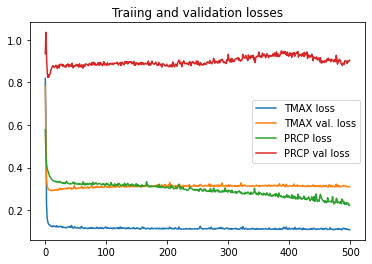

In [ ]:
#Train models on each parameter
tmaxModel, tmaxCosts = trainModel1D(train_in[0], train_labels[0], (len(train_in[0])-1), 0.2, 32, 500)
prcpModel, prcpCosts = trainModel1D(train_in[1], train_labels[1], (len(train_in[1])-1), 0.2, 32, 500)

#Plot the costs for reference
plt.title("Traiing and validation losses")
plt.plot(tmaxCosts.history["loss"], label="TMAX loss")
plt.plot(tmaxCosts.history["val_loss"], label="TMAX val. loss")

plt.plot(prcpCosts.history["loss"], label="PRCP loss")
plt.plot(prcpCosts.history["val_loss"], label="PRCP val loss")
plt.legend()

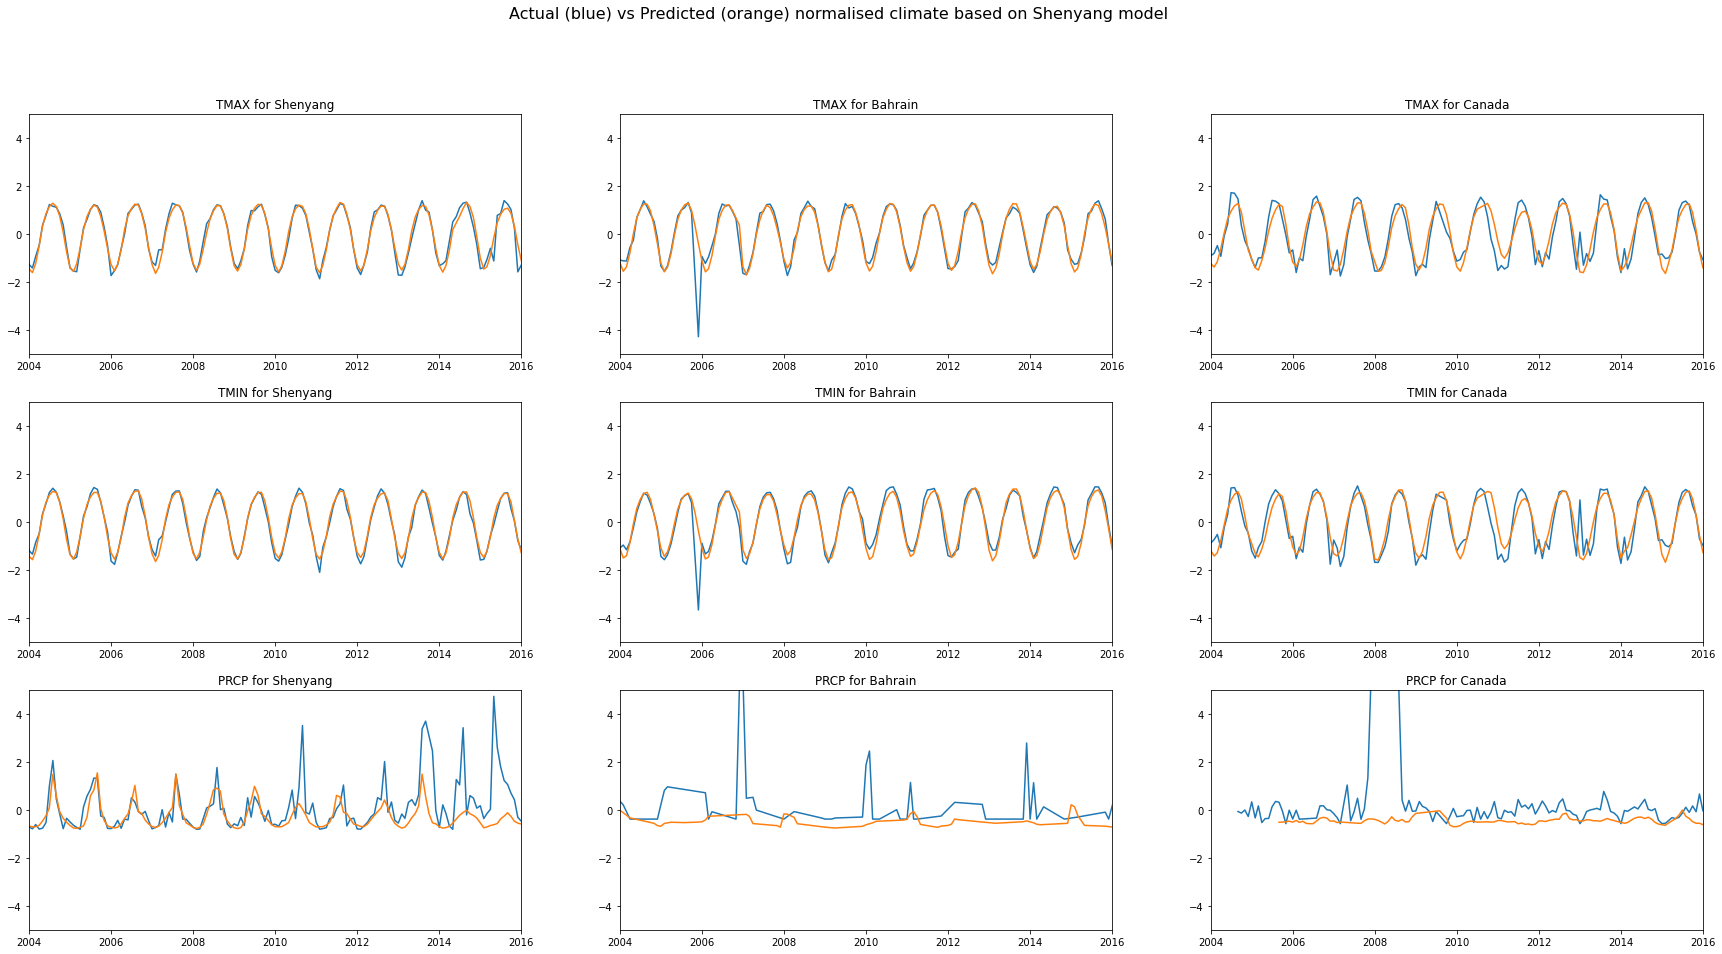

In [ ]:
#Test the data on each location for TMAX, TMIN and PRCP
testModel([tmaxModel, tmaxModel, prcpModel], ["Shenyang", "Bahrain", "Canada"], [300, 150, 201], ["TMAX", "TMIN", "PRCP"],yRange=[-5,5], dateRange=[date(2004,1,1), date(2016,1,1)])

Above, the models are passed to the `testModel` function for testing against a variety of other stations. Here, the Shenyang model is tested on data from Canada and Bahrain, two very different testing environments. The results are displayed in a grid below. As can be seen, temperature generalises well, but the precipitation results will be the subject of further analysis in the report. For simplicity, the TMIN values are predicted using the TMAX model, which produces acceptable results at the cost of a small deviaton in annual minimum temperatures.

# 6. Conclusion (but not the end!)
---
While the main body of detailed analysis and review is reserved for the report, there are a few immediately apparent observations that are worth commenting on. The first is the clear difficulty in making long range weather predictions, beyond identifying trends. Constructing functional precipitation models proved nearly impossible with the somewhat-patchy data and the approach used here. This mirrors real-world weather modelling however, which is something of a consolation. Less chaotic variables, such as maximum and minimum temperature, could be broadly predicted, but often without much numerical accuracy, and the behaviour of the models was at times inconsistent. 

The temperature climate models generalised well to other stations, and combining variations of the peak detection functions tested here with the climate precipitation models may be an avenue for further enabling generalised predictions, although that is outside of the scope of the code shown here.

The extensions also submitted as part of this project often extend similar techniques as used in this section, and this proved a worthwhile endeavour, particularly in guiding the direction of the Mars data analysis.

---
---

# Extension One: Interactive global climate prediction

## E1. Objectives and technical challenges
---
The objective of this extension is to create an interactive map of the world, providing a quickw way of visualising global trends in temperature, both historically and into the future. This was built to be an extension of the climate modelling functionality from the second compulsory task, and as such has a relatively high temporal resolution, predicting monthly averages rather than seasonal or annual ones. 

There are three steps to this extension:

1. Obtain historical climate data and calculate monthly averages
2. Use a climate model to predict from the last set of measurements to a specified point in time
3. Aggregate this data and visualise it with a heatmap

This was carried at as more of an exercise in data visualisation, and in network prediction stability, than strict accuracy in long range predictions. The reason for this primarily stems from the lack of available data for many of the stations, which often only had 15 years of data, preventing much of the

#E2. Data manipulation

##E2.1 Preprocessing and prediction
---

The data handling for this extension was relatively simple, performing much of the same climate tasks and had been done before, but scaled to 990 stations. The `getWorldTempMap` function iterates over these stations, retrieving their data and formatting it into NN-compatible formats. The final set of batches is used to generate the first prediction, which then becomes the last element of a new batch, with the first element popped off. This preserves the window used for prediction, effectively sliding it forward in time by a month per prediction. This allows for predictions to be made arbitrarily far into the future, although the veracity and stability of this system is discussed in the report.

In [ ]:
def getWorldTempMap(model, yearsToPredict, useFullData=False, fullData=None, maxNum=990, showPlot=False):
  '''
  Iterates over all 990 weather stations, retrieves the maximum temperatures, 
  predicts forward to 2040 using a supplied climate model, and then combines
  that with historical data to provide a full dataset.

  Inputs:

  model [NN]
              A fitted climate model with a single input and output.
  
  yearsToPredict [INT]
              How many years from the current data to predict (e.g 40)
  
  useFullData [BOOL]
              Whether to use a supplied dataset instead

  fullData  [ARR]
              Array containing the base climate data for 990 stations,
              so that it doesnt have to be rerieved multiple times.
              Not especially useful.

  Returns:

  coords [ARR]
              Array containing the coordinates of each station
  
  dates [ARR]
              Array containing the dates for each of each stations measurement
  
  temps [ARR]
              The temperatures for each month for each station

  stationNames [ARR]
              The names of eachs station
  
  out_fullData [ARR]
              The raw climate data used which can be used as the fullData input
              if the function is rerun.
  '''

  #Return arrays for the function
  coords = []
  stationNames = []
  dates = []
  temps = []
  out_fullData = []

  #The date to predict out to: 2021 + yearsToPredict -> target year
  targetDate = date(date.today().year + yearsToPredict, date.today().month, 1)

  #Announce the beginning of this arduous computation
  print("[+] Retrieving all the data... from all the stations")
  print("[+] Wish me luck.\n")

  #Iterate over each station and get tmax data only
  #Encapsulated in a try catch, as there are unhandled edge cases where the 
  #GHCND code fails to identify missing data, and this is easier than fixing it

  for id in range(0, maxNum):
    try:

      #Variable for the raw climate data
      climateData = None

      #If supplied, take it from the input, otherwise retrieve it
      if useFullData:
        climateData = fullData[id]
      else:
        climateData = getClimateParams(id, ["TMAX"], True, retLatLong=True)
      
      #Save to the return array
      out_fullData.append(climateData)

      #Get the dates of the next-year predictions
      predictionDates = climateData[0][0][36:,0] + timedelta(365)

      #Pull the latitude, longitude and name of the station
      lat, long = int(climateData[2].lat), int(climateData[2].lon)
      stationNames.append(climateData[2].name)

      #Convert the lat and long into positive values to use in a 
      #360x180 grid
      lat += 90
      long += 180

      #Convert the raw data into batch inputs
      batchInputs, batchLabels = getClimateTrainingData(climateData[0], 36, 0)
      preds = []
      predDates = []
      inputs = list(batchInputs[0][-36:])

      #Calculate how many sequential predictions are required to reach the
      #target year
      monthsRequired = (2+int((targetDate - predictionDates[-1]).days / 365) )*12

      #Calculate forward to the target date, predicting on the models predictions
      for i in range(0, monthsRequired):
        nextYear = model.predict_on_batch(np.array(inputs))
        preds.append(nextYear[0][0])
        inputs.append(nextYear)
        inputs.pop(0)

      #Save the corresponding dates for these predictions
      predDates.append(predictionDates[-1])
      for i in range(1, len(preds)):
        dateInNextMonth = predDates[i-1] + timedelta(32)
        dateInNextMonth = date(dateInNextMonth.year, dateInNextMonth.month, 1)
        predDates.append(dateInNextMonth)

    #Catch keyboard interrupts in case we decide to abort
    except KeyboardInterrupt:
      return

    #Suppress other errors
    except Exception as e:
      continue
    
    if showPlot:
      plt.figure(figsize=(10,5))
      plt.plot(predictionDates, batchLabels[0], label="Historical")
      plt.plot(predDates, preds, label="Prediction")
      plt.legend()
      plt.title(("Historical and predicted temperature for station " + str(id)))
      plt.xlabel("Date")
      plt.ylabel("Normalised temperature")


    #Un-normalise the data so that it can be compared on a heatmap
    finalData = (np.array(list(batchLabels[0]) + list(preds)) * climateData[1][0][1]) + climateData[1][0][0]

    #Combine the date arrays of the normal and NN predicted data
    finalDates = list(predictionDates) + list(predDates)

    #Save the coordinates / dates / temps for the eventual func return
    coords.append([lat, long])
    dates.append(finalDates)
    temps.append(finalData)

    #Progress bar, update very 5 stations
    if(id % 5 == 0 and id > 0):
      print(">5>", end="")
    if(id % 100 == 0 and id > 0):
      print("\n\n[OK] Processed", id)

  #Return the complete datasets
  return coords, dates, temps, stationNames, out_fullData


## E2.2 Data visualisation
---
With the data processed in this way, it can now be passed to `displayMapData`, which translates the supplied station latitude and longitude into a location within a 360x180 grid, representing a map of the Earth in 1x1 degree tiles. This is a relatively simple process, where, the coordinates are used as the indices of elements within the array, allowing them to be set directly. The advantage of this coordinate system is that it allows for a map to be generated directly from the station positions, which represent a rough shape of the Earth's landmasses, rather than overlaying terrain borders or importing additional modules.

The colour scheming is defined with maximum and minimum temperatures of +- 55 degrees celsius, a value that was set empirically to provide the best 

This function returns the data for a specific point in time, as specified by its inputs. This allows for specific dates to be retrieved and displayed in sequence, which is required for interactive widgets. 

There are a few key caveats, however. As stated earlier, some stations came online later than others, or are missing chunks of data. In these cases, if there are measurements made within five years, and in the same season (defined as one month either side of the target month), the closest one is chosen. This aims to strike a balance between maintaining a cohesive map while not showing data that is completely inappropriate in some cases. 


In [ ]:
def displayMapData(mapData, year, month):
  '''
  Displays the map data from the above function at a specified time.

  Inputs:

  mapData [ARR]
                Array of temeratures from the stations, as formatted by the 
                getWorldTempMap function
  
  year    [INT]
                The year to display
  
  month   [INT]
                The month to display
  
  Returns:

  A heatmap of the combined data, geographically arranged using the station
  coordinates.
  '''

  #Get the date to display using the inputs
  mapDate = date(year,month,1)

  #Fill the map array with -100 degree temperatures to zero the heatmap
  worldGrid = np.full((180,360),-100.)

  #Extract the relevant data from the mapData variable
  coords = mapData[0]
  dates = mapData[1]
  temps = mapData[2]
  names = mapData[3]

  #Set variables for getting the max / min temperatures and locations
  #Setting them like this ensures they get set by the stations no matter what
  maxTemp = -200
  maxCoords = []
  minTemp = 200
  minCoords = []
  maxName = ""
  minName = ""

  validStations = 0

  #Iterate over the dates of each stations measurements to find the closest
  #reading to the one reqeusted by the inputs
  for j in range(0, len(dates)):

    #Select this stations date array
    d = dates[j]

    #Variables for storing the closest values
    valIndex = -1

    #If the month is exactly in the dataset
    if mapDate in d:
      valIndex = d.index(mapDate)

    #If this data is missing (in the case of historical measurements)
    #Search for the closest measurement: must be in the same season, and within five years
    else:
      #Return variables to use for comparison
      yearDiff = 1000
      monthDiff = 1000
      closestApproach = -1

      #Iterate over the dates and find the year and month difference
      for i in range(0, len(d)):
        yDiff = d[i].year - year
        mDiff = d[i].month - month

        #If we're now leaving the acceptable region, quit
        if yDiff > 5:
          valIndex = closestApproach
          break

        #Otherwise, calculate the absolute distance from the desired date
        else:
          yDiff = abs(yDiff)
          mDiff = abs(mDiff)

        #See if this date is closer than the last best estimate
          if yDiff < 5 and mDiff < 2:
            if yDiff < yearDiff or (yDiff == yearDiff and mDiff < monthDiff):
              closestApproach = i
              yearDiff = yDiff
              monthDiff = mDiff

        


    #Get the coordinates of this station and use it to set the map array elems
    lat, long = coords[j]

    #If there was valid data, save the temperature
    if valIndex != -1:
      worldGrid[lat][long] = temps[j][valIndex]
      validStations += 1

    #Otherwise, hide it from the map
    else:
      worldGrid[lat][long] = -100


    #If above the max or below the min temperature, update them to display
    if valIndex != -1:
      if temps[j][valIndex] > maxTemp:
        maxTemp = temps[j][valIndex]
        maxName = names[j]
        maxCoords = lat,long
      if temps[j][valIndex] < minTemp:
        minTemp = temps[j][valIndex]
        minCoords = lat, long
        minName = names[j]

  #Output the max and min global temperatures on this specific date
  tempString = "Max temp: " + str(maxTemp.round(2)) + " Celsius @ " + str(maxName) + " " + str(maxCoords)
  tempString += "\n\nMin temp: " + str(minTemp.round(2)) + " Celsius @ " + str(minName) + " " + str(minCoords)
  tempString += "\n\nTotal of " + str(validStations) + "/" + str(len(dates)) + " stations online"
  #Plot the map and colourise
  fig, ax = plt.subplots(1,1, figsize=(20,35))
  cax = fig.add_axes([0.95, 0.4, 0.05, 0.2])
  im = ax.imshow(worldGrid, origin="lower", cmap="magma", vmin=-70, vmax=70)
  fig.colorbar(im, cax=cax)

  ax.text(0.01, 0.03, tempString,
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='white', fontsize=12)
  
  ax.set_title(mapDate, fontsize=15)  


##E2.3 Training the predictive model
---
The model used here is one based on the Shenyang data, as it seemed to be particular stable, making it a viable candidate for long term predictions. Unfortunately, there was a tendency for recursive predictions to suddenly converge to a single value. This was adjusted for by increasing the input window size, applying additional stabilisation to the predictions, and this appeared to resolve many of the issues. Relatively small numbers of training iterations were used, to try and avoid potential overfitting issues, although the success of this is debateable.

In [ ]:
data, distInfo = getClimateParams(912, ["TMAX"], True)
train_in, train_labels = getClimateTrainingData(data, 36, 12)
globalModel, globalCosts = trainModel1D(train_in[0], train_labels[0], (len(train_in[0])-1), 0.3, 32, 100)

To verify that the model is stable, the map builder is first run with two overrides, only looking at first station, and outputting the results. The full process is still carried out on the station, but the loop doesn't continue. As can be seen below, the current model is very stable when predicting out until 2040. However, it may be too stable to be sensitive to temperature trends, which will be examined later.

[+] Retrieving all the data... from all the stations
[+] Wish me luck.



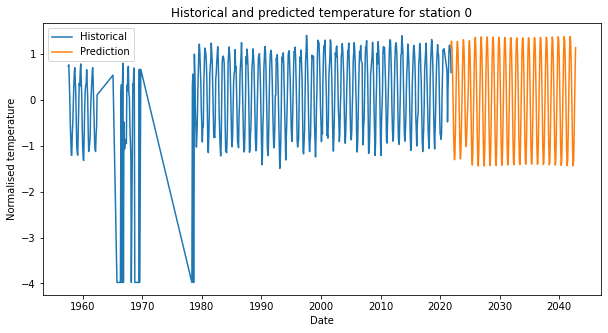

In [ ]:
#Retrieve the map data - take a seriously long time to predict everything
testMapData = getWorldTempMap(globalModel, 20, maxNum=1, showPlot=True)

With the model's stability verified, the final step is to download the full dataset, and predict the monthly values up to 2040. This is a lengthy process, taking upwards of 25 minutes.

__As stated before, there are screenshots at the bottom if running it takes too long.__

In [ ]:
#Last warning: This will take a while
mapData = getWorldTempMap(globalModel, 20)

[+] Retrieving all the data... from all the stations
[+] Wish me luck.

>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>

[OK] Processed 100
>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>

[OK] Processed 200
>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>

[OK] Processed 300
>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>

[OK] Processed 400
>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>

[OK] Processed 500
>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>

[OK] Processed 600
>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>

[OK] Processed 700
>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>

[OK] Processed 800
>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>

[OK] Processed 900
>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>>5>

#E3. The Map

## E3.1 Interacting with the data
---
With everything in place, it can be passed to the interactive map function, and displayed out. The month and year were made independantly controllable to allow for better qualitative comparisons to be made, either comparing the same month across multiple years, or different months in the same year. Also displayed are the maximum and minimum station temperatures for any given point in time. 
The last feature of note is the colourbar on the right hand side, acting as a key for the display. The background has specifically had an extremely low temperature set, hence the black appearance.

In [ ]:
#Launch the interactable map and let the user play around with the date and month
yw = widgets.IntSlider(value=2030, min=1950, max=2040)
mw = widgets.IntSlider(value=1, min=1, max=12)
interact(displayMapData, mapData=fixed(mapData), year=yw, month=mw)

interactive(children=(IntSlider(value=2030, description='year', max=2040, min=1950), IntSlider(value=1, descri…

<function __main__.displayMapData>

## E3.2 Preliminary Observations and Conclusion
---
Despite relatively low expectations, the map provided a surprisingly interesting visualisation of global temperature distribution. Moreover, it doubled as a timelapse of the coverage of the GHCND network as a whole, beginning with North America, Europe and Australia in 1950, and expanding into Asia, South America and Africa during the 1960s and 1970s. While not particularly helpful in climate modelling, it is an interesting byproduct.

Scrolling forward to 2030 and 2040 indicates a significant increase in temperature at high latitudes, with winter temperatures in northern Siberia reaching 20 degrees celsius, compared to  -10 in earlier years. This is rather dramatic, and the magnitude of the change is likely the product of the recursive predictions, but aligns with the current expectations that average temperatures will rise, with a severe impact on the Northern Hemisphere, particularly the Arctic Circle. Interestingly, the global maximum and minimum temperatures do not increase or vary as severely as the temperatures in the northern latitudes, suggesting that the temperature increase is not uniform across the Earth's surface. Further analysis is carried out in the report, particularly regarding the predicted trends. 

This proved to be particularly interesting, especially in efficiently trying to find and eliminate errors and missing data, and the functionality of the final result was unexpected. The validity of the predictions, as well as further analysis and review

---
---


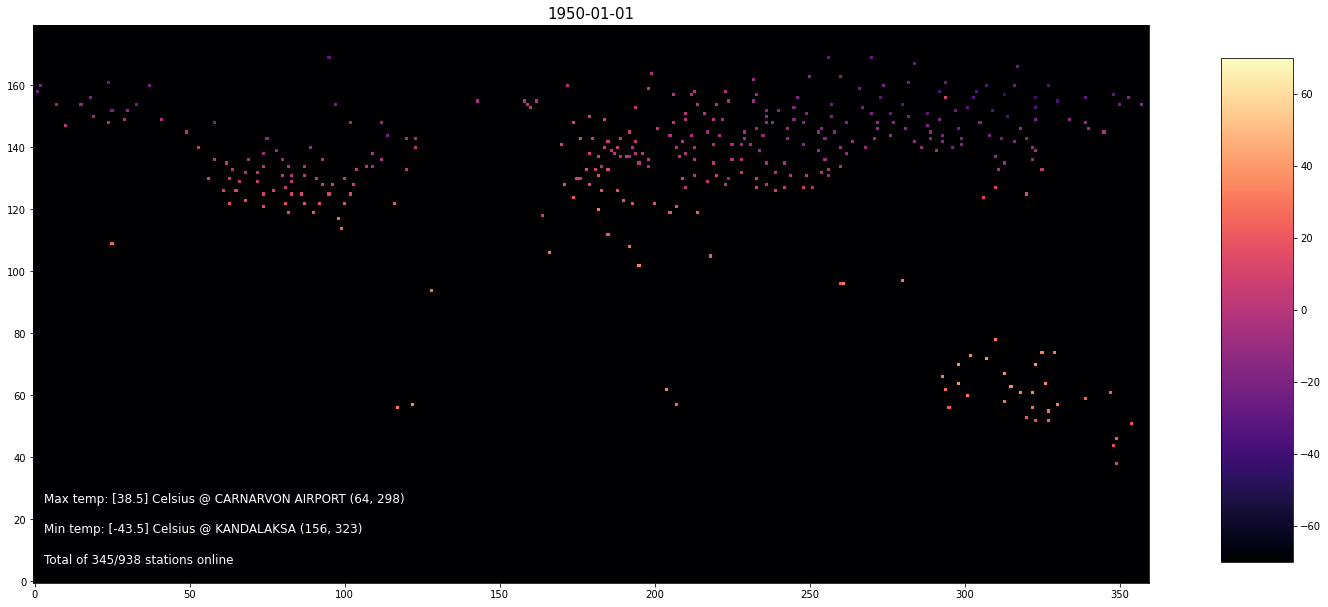

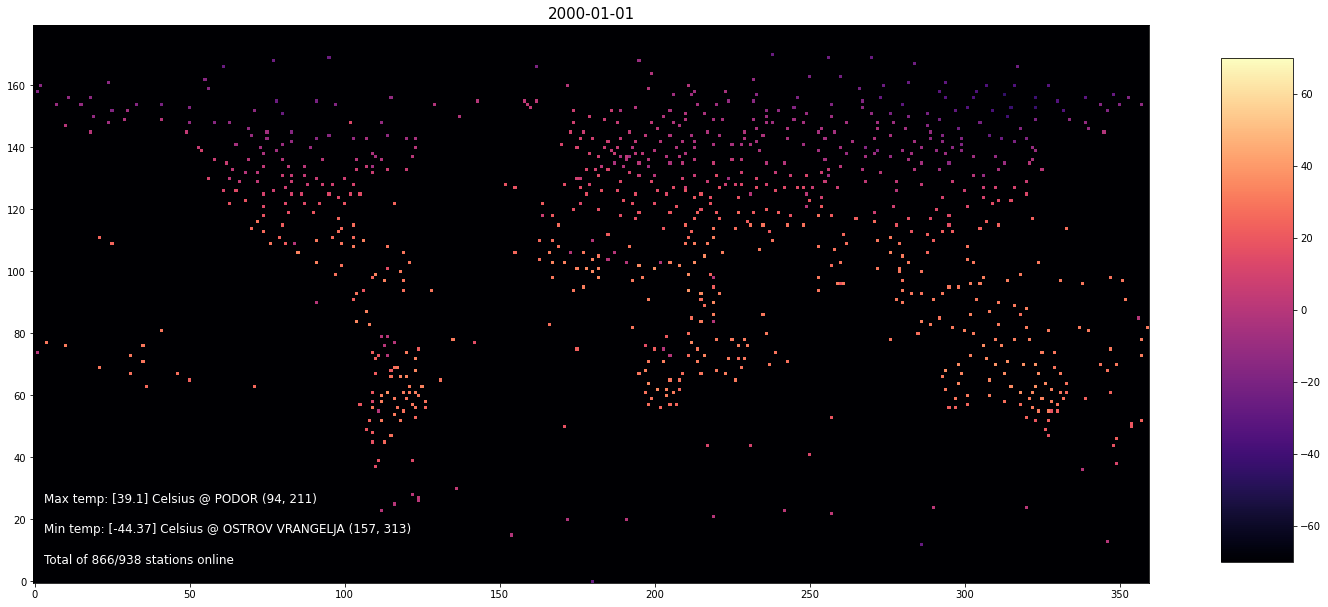

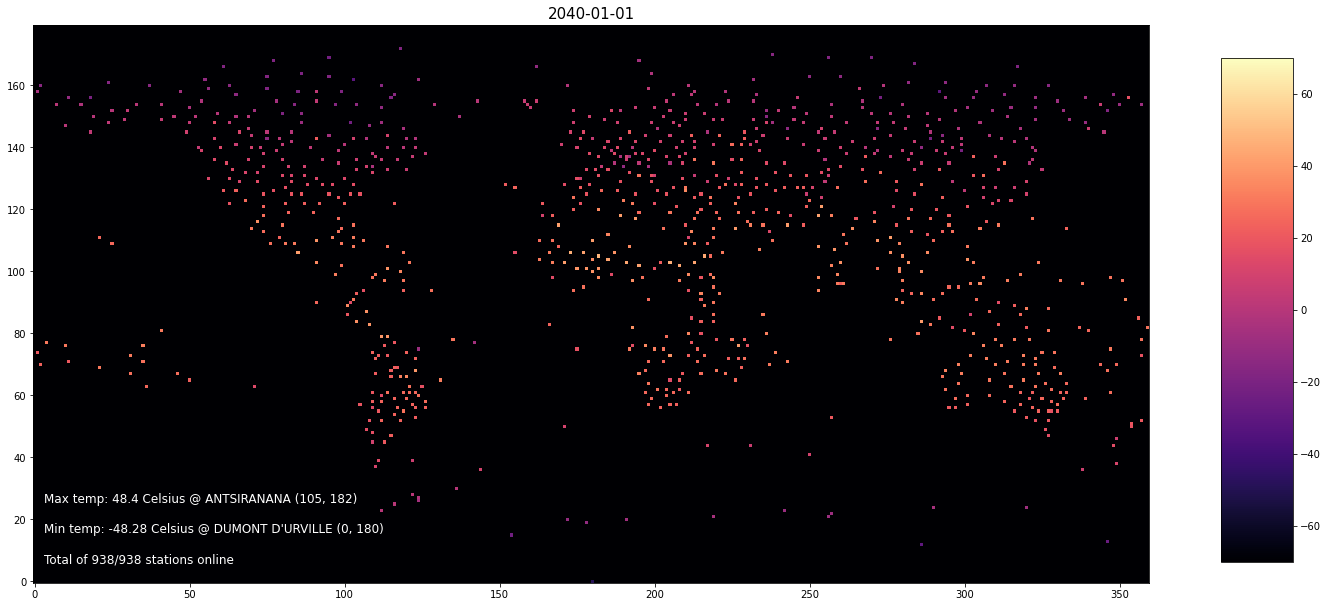